In [1]:
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

In [104]:
np.random.seed(335)
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

# set dimension
n = 10000
d = 30

# set lambda
lamb = 10

start = True
while start:
    # generate random X
    X = np.random.rand(n, d)
    
    # compute Q
    Q = 0.5 * np.linalg.inv(X.T.dot(X))

    # test if Q is >= 0
    start = ~is_pos_def(Q)
    
# generate random y
y = np.random.rand(n, 1) # np.random.binomial(1, 0.5, (n, 1))
#y = np.random.binomial(1, 0.75, (n, 1))

# compute p, A and b
p = - np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
A = np.concatenate([np.eye(d), - np.eye(d)], axis=0)
b = lamb * np.ones((2 * d, 1))

# possible starting point
v0 = (lamb / 2) * np.ones((d, 1))

# set target precision
eps = 1e-3

In [3]:
def test(x):
    return x.T.dot(Q.dot(x)) + p.T.dot(x)

def f(Q, p, A, b, x): 
    phi = 0
    for i in range(np.shape(A)[0]):
        if float(b[i, 0] - A[i, :].dot(x)) > 0:
            phi -= np.log(float(b[i, 0] - A[i, :].dot(x)))
        else:
            return np.inf
    return float(x.T.dot(Q.dot(x))) + float(p.T.dot(x)) + phi

def grad_f(Q, p, A, b, x):
    phi = np.zeros_like(A[0, :])
    for i in range(np.shape(A)[0]):
        phi += A[i, :].T / float(b[i, 0] - A[i, :].dot(x))
    return (Q.T + Q).dot(x) + p + phi.reshape(len(phi), 1)
        
def hess_f(Q, A, b, x):
    phi = np.zeros_like(np.outer(A[0, :], A[0, :]))
    for i in range(np.shape(A)[0]):
        phi +=  (1 / float(A[i, :].dot(x) - b[i, 0]) ** 2) * np.outer(A[i, :], A[i, :])
    return Q + Q.T + phi

In [76]:
def backtracking_line_search(Q, p, A, b, x, delta, grad_f):
    alpha, beta, t = 0.25, 0.55, 10
    f_eval = f(Q, p, A, b, x)
    cst = float(grad_f.T.dot(delta))
    len_delta = np.linalg.norm(delta)
    while f(Q, p, A, b, x + t * delta) >= (f_eval + alpha * t * cst):
        t *= beta
        if t * len_delta < 1e-6: # too small
            print('too small')
            return t
    return t

def centeringstep(Q, p, A, b, t, v0, eps):
    v_seq, hist = [v0], []
    decrement = 1e5 # just for starting
    while decrement / 2 > eps:
        grad = grad_f(t * Q, t * p, A, b, v_seq[-1])
        delta = - np.linalg.inv(hess_f(t * Q, A, b, v_seq[-1])).dot(grad) # newton step 
        decrement = grad.T.dot(- delta) # decrement
        gamma = backtracking_line_search(t * Q, t * p, A, b, v_seq[-1], delta, grad) # backtrackling line search
        v_seq.append(v_seq[-1] + gamma * delta) # update v_star
        hist.append(decrement / 2) # save decrement 
    return v_seq, hist
    
def barrmethod(Q, p, A, b, v0, eps, mu):
    m, v_seq, newt_steps, precision = np.shape(A)[0], [v0], [], []
    t = 1
    while m / t >= eps:
        hist_x, hist_decr = centeringstep(Q, p, A, b, t, v_seq[-1], eps) # minimize t * f_0 + phi
        v_seq.append(hist_x[-1]) # update v_seq (x_star)
        newt_steps.append(len(hist_decr))  # update newton steps
        precision.append(m / t) # update newton steps
        t *= mu
    return v_seq, newt_steps, precision

In [111]:
v_hist, newton_steps, precision_criterion = {}, {}, {}
mus = [2, 15, 50, 100, 150, 200]
for mu in mus:
    # compute with barrier
    v_seq, newt_steps, precision = barrmethod(Q, p, A, b, v0, eps, mu)
    
    # save data
    v_hist[mu] = v_seq 
    newton_steps[mu] = np.cumsum(newt_steps)
    precision_criterion[mu] = precision
    
    # get some updates
    display(Math(r'With ~~ \mu=%d ~~the~~optimal~~solution~~for~~v^{*^T}Qv^* + p^Tv^*~~is: %.4f'%(mu, test(v_seq[-1]))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

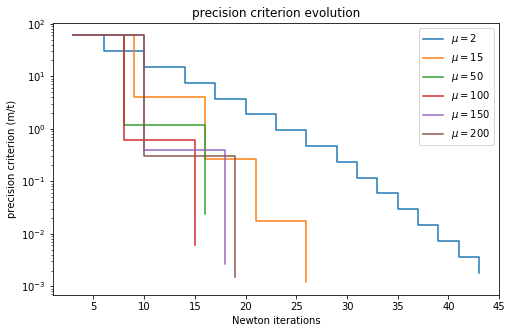

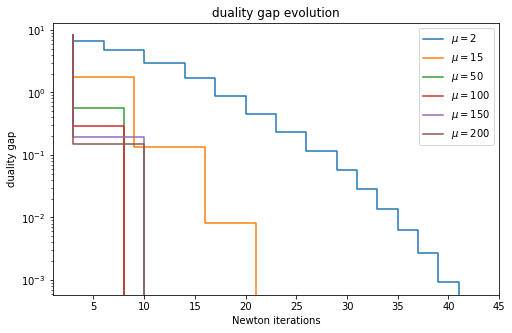

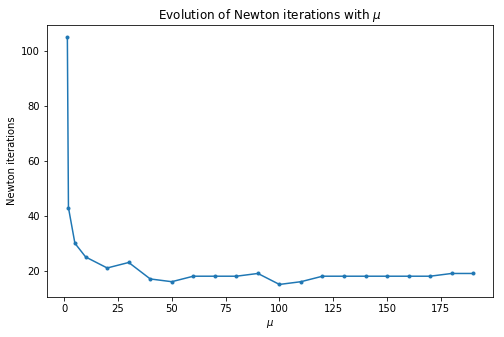

In [112]:
# precision criterion
plt.figure(figsize=(8, 5))
for mu in mus:
    plt.step(newton_steps[mu], precision_criterion[mu], where='post', label=r'$\mu=$' + str(mu))
plt.yscale('log')
plt.title('precision criterion evolution')
plt.xlabel("Newton iterations")
plt.ylabel("precision criterion (m/t)")   
plt.legend()
plt.show()

# duality gap evolution
plt.figure(figsize=(8, 5))
for mu in mus:
    f_star = min([test(x) for x in v_hist[mu][1:]])
    plt.step(newton_steps[mu], [float(test(x) - f_star) for x in v_hist[mu][1:]],
             label=r'$\mu=$' + str(mu))
plt.yscale('log')
plt.title('duality gap evolution')
plt.xlabel("Newton iterations")
plt.ylabel("duality gap")  
plt.legend()
plt.show()

v_hist, newton_steps, precision_criterion = {}, {}, {}
mus = [1.5, 2, 5] + [10 * i for i in range(1, 20)]
for mu in mus:
    # compute with barrier
    v_seq, newt_steps, precision = barrmethod(Q, p, A, b, v0, eps, mu)
    
    # save data
    v_hist[mu] = v_seq 
    newton_steps[mu] = np.cumsum(newt_steps)
    precision_criterion[mu] = precision

# mu and Newton iterations
plt.figure(figsize=(8, 5))
plt.plot(mus, [newton_steps[mu][-1] for mu in mus], '.-')
plt.title(r'Evolution of Newton iterations with $\mu$')
plt.xlabel(r"$\mu$")
plt.ylabel("Newton iterations")
plt.show()